In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import scqubits as qubit
import scqubits.utils.sweep_plotting as splot
from scqubits import HilbertSpace, InteractionTerm, ParameterSweep

import numpy as np
import qutip as qt

# Working with composite Hilbert spaces and interfacing with QuTiP

## Example: two Cooper pair boxes coupled to one resonator mode
$\displaystyle H=\sum_{\alpha=1,2}\sum_{j} E_j^{(\alpha)}|\alpha j\rangle\langle \alpha j| + \omega_r a^\dagger a + \sum_{\alpha=1,2}g^{(\alpha)} n_\alpha(a+a^\dagger)$

### Define Hilbert space components, initialize HilbertSpace object

In [2]:
# Set up the components / subspaces of our Hilbert space

CPB1 = qubit.Transmon(
    EJ = 40.0,
    EC = 0.2,
    ng = 0.3,
    ncut = 40,
    truncated_dim = 3     # after diagonalization, we will keep 3 levels
)

CPB2 = qubit.Transmon(
    EJ = 30.0,
    EC = 0.15,
    ng = 0.0,
    ncut = 10,
    truncated_dim = 4
)

resonator = qubit.Oscillator(
    omega = 6.0,
    truncated_dim=4  # up to 3 photons (0,1,2,3)
)


# Form a list of all components making up the Hilbert space.
hilbertspace = HilbertSpace([CPB1, CPB2, resonator])

Obtain the bare Hamiltonian of the non-interacting subsystems:

In [3]:
bare_hamiltonian = hilbertspace.get_bare_hamiltonian()
bare_hamiltonian

Quantum object: dims = [[3, 4, 4], [3, 4, 4]], shape = (48, 48), type = oper, isherm = True
Qobj data =
[[-63.0886372    0.           0.         ...   0.           0.
    0.        ]
 [  0.         -57.0886372    0.         ...   0.           0.
    0.        ]
 [  0.           0.         -51.0886372  ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ... -24.66024074   0.
    0.        ]
 [  0.           0.           0.         ...   0.         -18.66024074
    0.        ]
 [  0.           0.           0.         ...   0.           0.
  -12.66024074]]

### Set up interaction terms between individual subsystems

In [4]:
g1 = 0.1  # coupling resonator-CPB1 (without charge matrix elements)
g2 = 0.2  # coupling resonator-CPB2 (without charge matrix elements)

interaction1 = InteractionTerm(
    g_strength = g1,
    hilbertspace = hilbertspace,
    op1 = CPB1.n_operator(),
    subsys1 = CPB1,
    op2 = resonator.creation_operator() + resonator.annihilation_operator(),
    subsys2 =resonator
)

interaction2 = InteractionTerm(
    g_strength = g2,
    hilbertspace = hilbertspace,
    op1 = CPB2.n_operator(),
    subsys1 = CPB2,
    op2 = resonator.creation_operator() + resonator.annihilation_operator(),
    subsys2 =resonator
)

Now insert the interaction terms into the HilbertSpace object.

In [5]:
interaction_list = [interaction1, interaction2]

hilbertspace.interaction_list = interaction_list

Now that the interactions are specified, the full Hamiltonian of the coupled system can be obtained via:

In [6]:
dressed_hamiltonian = hilbertspace.get_hamiltonian()
dressed_hamiltonian

Quantum object: dims = [[3, 4, 4], [3, 4, 4]], shape = (48, 48), type = oper, isherm = True
Qobj data =
[[-6.30886372e+01  3.00000000e-02  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 3.00000000e-02 -5.70886372e+01  4.24264069e-02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  4.24264069e-02 -5.10886372e+01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -2.46602407e+01
   4.24264069e-02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  4.24264069e-02
  -1.86602407e+01  5.19615242e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   5.19615242e-02 -1.26602407e+01]]

Since the composite Hamiltonian is a `qubit.Qobj`, The eigenvalues and eigenvectors can be now be obtained via the usual QuTiP routine:

In [7]:
evals, evecs = dressed_hamiltonian.eigenstates()
print(evals)

[-63.09882162 -57.51117008 -56.87227527 -55.29218444 -51.98550321
 -51.35767948 -50.66934171 -49.70520951 -49.06777392 -47.69022345
 -46.53142187 -45.88108594 -45.19575121 -44.47305945 -44.17976179
 -43.55319972 -42.86633702 -42.08699951 -41.43121539 -40.7547869
 -39.64907153 -38.72646813 -38.51906976 -38.08023011 -37.41317134
 -36.68940288 -36.55216425 -35.89842142 -35.19290582 -34.72212155
 -32.97102102 -32.83554664 -31.86163739 -31.09583961 -30.75080583
 -30.41879985 -29.75103588 -29.0051601  -28.0131227  -26.9241389
 -25.30080703 -25.07695247 -24.17961912 -23.05451574 -20.26887901
 -19.22166541 -17.39940704 -12.57692797]


# Sweeping over an external parameter

scqubits provides the class `ParameterSweep` to facilitate computation of spectra as function of an external parameter. For efficient usage in the `Explorer` class, computed bare and dressed spectral data are stored internally. A sweep object is initialized as follows.

Consider the case where both `CPB1` and `CPB2` subsystems are flux-tunable split-junction transmons with different loop areas. 

In [11]:
param_name = 'flux'                          # name of varying external parameter
param_vals = np.linspace(-0.5, 0.5, 100)     # parameter values

subsys_update_list = [CPB1, CPB2]                  # list of HilbertSpace subsystems which are affected by parameter changes         

def update_hilbertspace(param_val):     # function that shows how Hilbert space components are updated
    CPB1.EJ = 20*np.abs(np.cos(np.pi * param_val))
    CPB2.EJ = 15*np.abs(np.cos(np.pi * param_val * 0.8))

    
sweep = ParameterSweep(
    param_name=param_name,
    param_vals=param_vals,
    evals_count=10,
    hilbertspace=hilbertspace,
    subsys_update_list=subsys_update_list,
    update_hilbertspace=update_hilbertspace,
    interaction_list=interaction_list
)


Once the data has been generated, the spectrum can be plotted as a function of the parameter value:

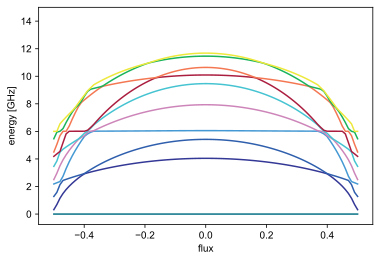

In [12]:
splot.dressed_spectrum(sweep);